In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
from skimage.transform import resize
from skimage import color,exposure
rd_seed = 5
np.random.seed(rd_seed)
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

### Création d'un dataset pandas avec l'adresse de chaque image

On crée un grand tableau panda ou chaque ligne correspond a une image

In [6]:
data_df = pd.DataFrame(columns = ["Class","Class number","dir"])
class_num = {"cloudy":0,"rain":1,"shine":2,"sunrise":3}
for class_dir in os.listdir("C:/Users/Lambert/Desktop/ML/weather_recognition/data/"):  #Search for all jpg into a file
    for filename in os.listdir("C:/Users/Lambert/Desktop/ML/weather_recognition/data/"+class_dir) :
        new_row = pd.DataFrame([[class_dir,class_num[class_dir],"C:/Users/Lambert/Desktop/ML/weather_recognition/data/"+class_dir+"/"+filename]],columns = ["Class","Class number","dir"])
        data_df = pd.concat([data_df,new_row])
data_df.reset_index(inplace=True,drop=True)
data_df.to_csv("C:/Users/Lambert/Desktop/ML/weather_recognition/data/data.csv")
data_df.head(5)

NotADirectoryError: [WinError 267] Nom de répertoire non valide: 'C:/Users/Lambert/Desktop/ML/weather_recognition/data/data.csv'

In [5]:
data_df = pd.read_csv("C:/Users/Lambert/Desktop/ML/weather_recognition/data/data.csv",index_col=0)

In [6]:
def show_ds(data_set):
    plt.figure(figsize=(15,15))
    size = data_set["Class number"].max()+1
    for i in range(len(data_set["Class number"].unique())):
        sample = data_set.loc[data_df["Class number"]==i].sample(n=size,random_state=rd_seed).reset_index(drop=True)
        for k in range(len(data_set["Class number"].unique())):
            plt.subplot(int(size),int(size),int(i*size+1+k))
            image = io.imread(sample.loc[k,"dir"])
            plt.imshow(image)

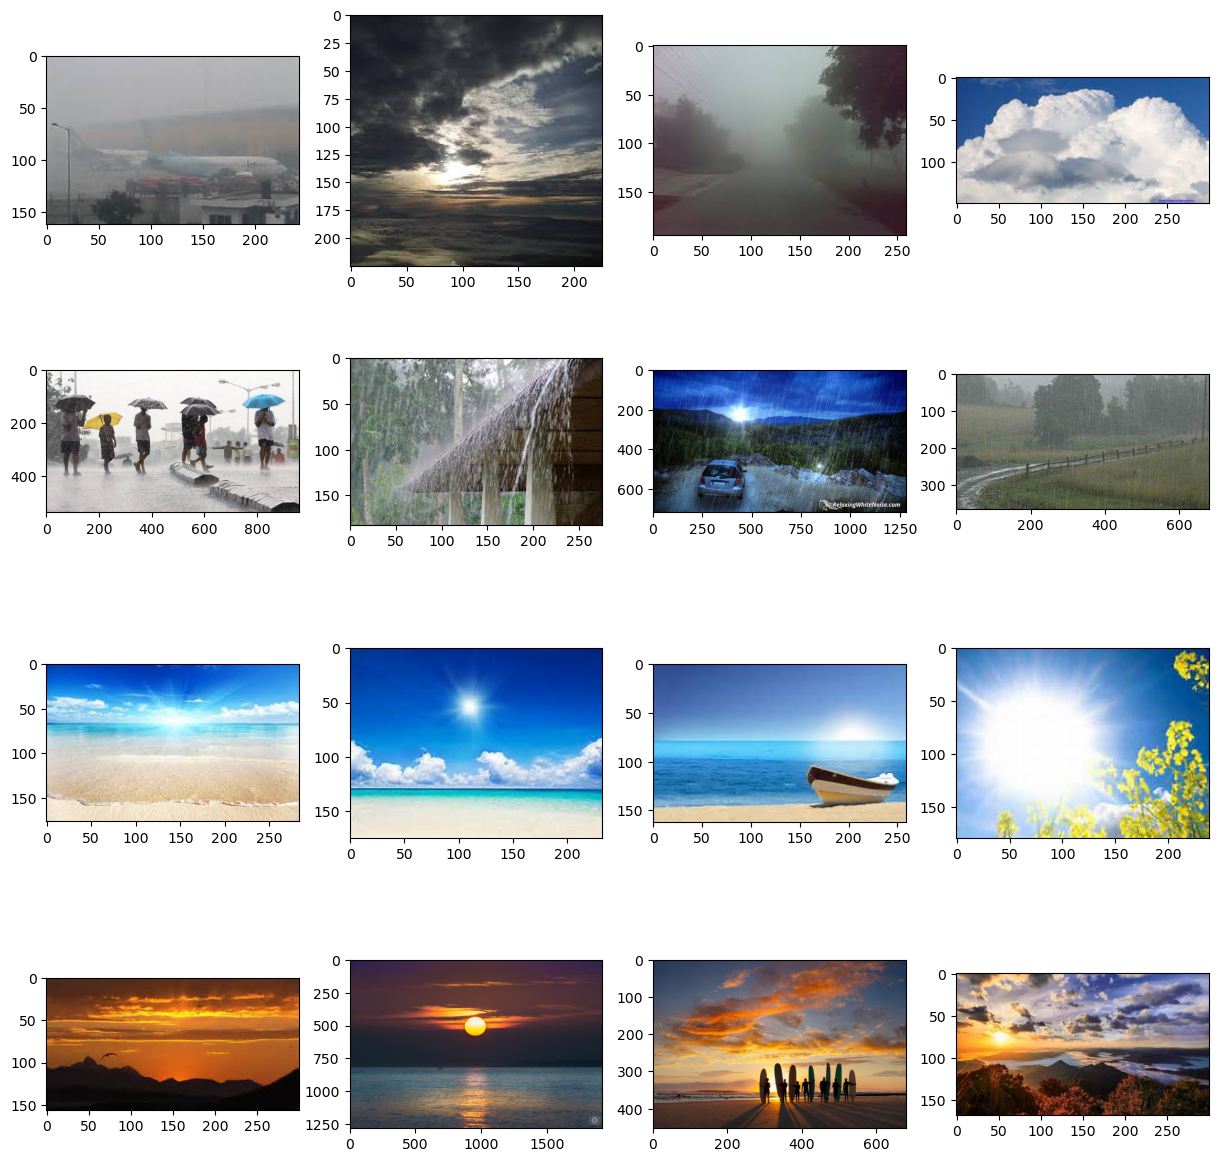

In [7]:
show_ds(data_df)

### Réduction des tailles et enhancement

On va fabriquer plusieurs datasets avec des images de tailles différentes et eventuelement des transformation ( niveau de gris / réajustement des histogrammes etc)

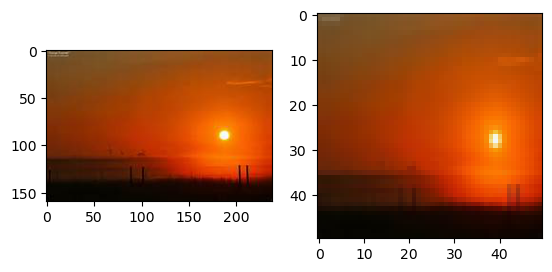

In [8]:
image = io.imread(data_df.loc[1000,"dir"])
image_resized = resize(image, (50,50),anti_aliasing=True)

plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(image_resized)

In [9]:
def enhance(data_dir,new_data_dir,R = True,size=50, equalized = True, greyscale=True):
    os.makedirs(new_data_dir,exist_ok=True)
    new_name = "data"
    if resize :
        new_name += "_R"+"_"+format(size)
        
    if equalized :
        new_name+= "_EQ"
    
    if greyscale :
        new_name+= "_GR"    
    
    os.makedirs(new_data_dir+"/"+new_name,exist_ok=True)
    
    
    for class_dir in os.scandir(data_dir):
        new_path = new_data_dir+"/"+new_name+"/"+class_dir.name
        if class_dir.is_dir():
            os.makedirs(new_path,exist_ok=True)
            for filename in tqdm(os.listdir(class_dir)):
                image = io.imread(class_dir.path+"/"+filename)
                if resize:
                    image = resize(image, (size,size),anti_aliasing=True)
                    # print(image.shape)
                # print(new_path)
                if greyscale:
                    try:
                        image = color.rgb2gray(image)
                    except:
                        print("bug")
                if equalized:
                    try:
                        hsv = color.rgb2hsv(image)
                        hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
                        image = color.hsv2rgb(hsv)
                    except:
                        image = exposure.equalize_hist(image)
                
                
    
                plt.imsave(new_path+"/"+filename,image)
    df = pd.DataFrame(columns = ["Class","Class number","dir"])
    class_num = {"cloudy":0,"rain":1,"shine":2,"sunrise":3}
    for class_dir in os.listdir( new_data_dir+"/"+new_name):  #Search for all jpg into a file
        for filename in os.listdir( new_data_dir+"/"+new_name+"/"+class_dir) :
            new_row = pd.DataFrame([[class_dir,class_num[class_dir],new_data_dir+"/"+new_name+"/"+class_dir+"/"+filename]],columns = ["Class","Class number","dir"])
            df = pd.concat([df,new_row])
    df.reset_index(inplace=True,drop=True)
    df.to_csv(new_data_dir+"/"+new_name+"/data.csv")
    return None
# enhance("C:/Users/Lambert/Desktop/ML/weather_recognition/data/","C:/Users/Lambert/Desktop/ML/weather_recognition/data_enhanced")

In [134]:
enhance("C:/Users/Lambert/Desktop/ML/weather_recognition/data/","C:/Users/Lambert/Desktop/ML/weather_recognition/data_enhanced")

 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [00:12<00:01, 26.08it/s]

bug
bug


 22%|██████████████████                                                               | 48/215 [00:06<00:48,  3.47it/s]

bug


 15%|███████████▊                                                                     | 37/253 [00:03<00:17, 12.38it/s]

bug
bug


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [02:00<00:00,  2.97it/s]


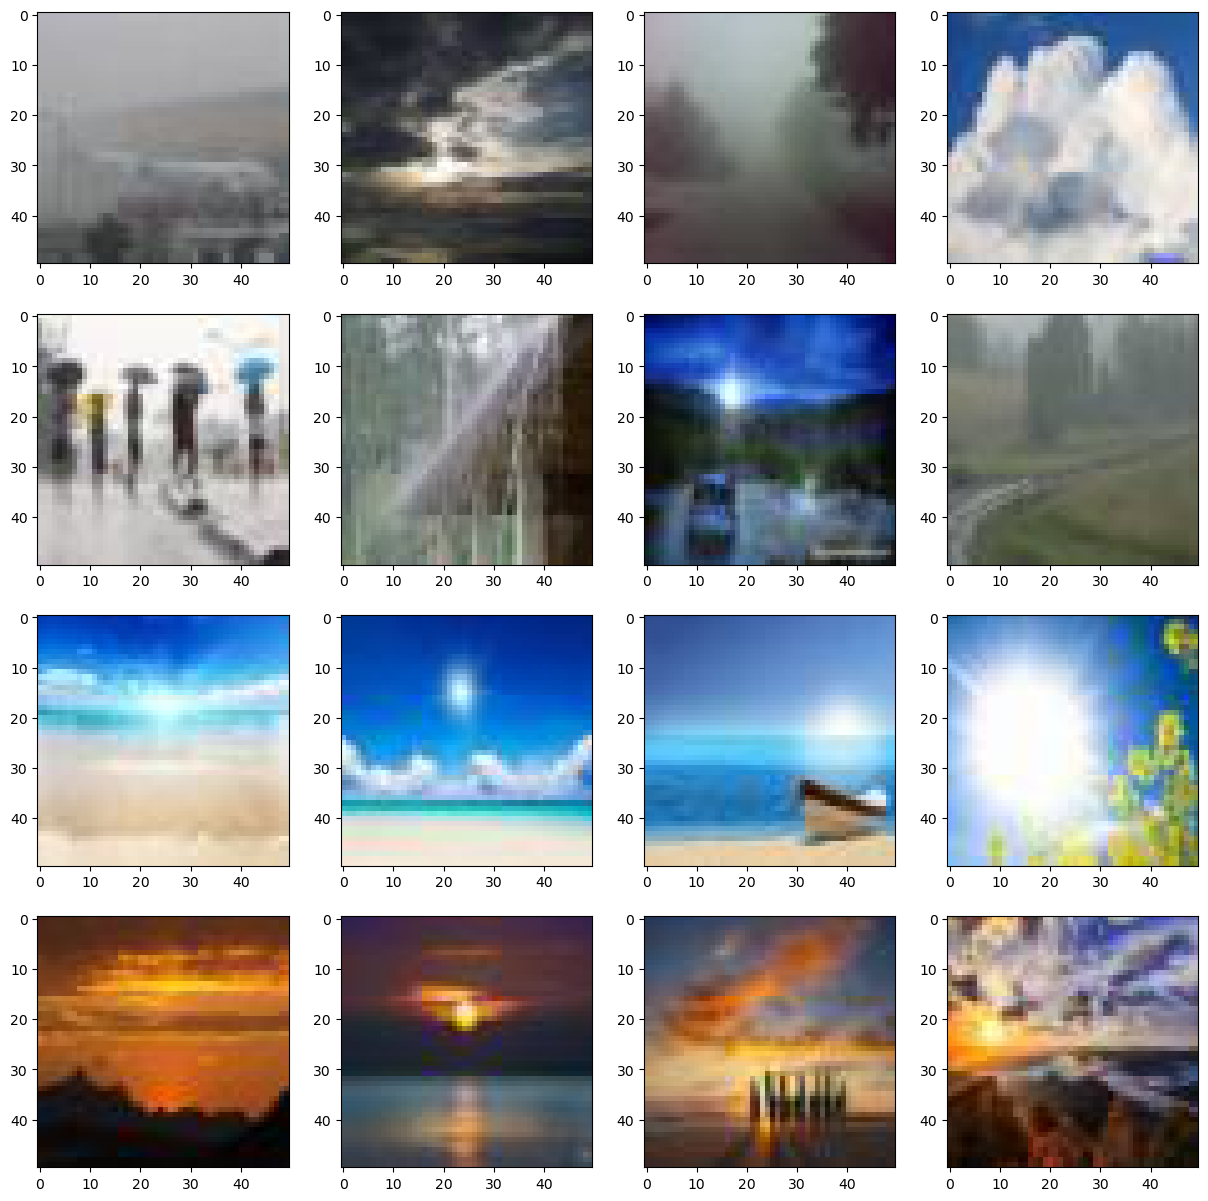

In [10]:
data_resized = pd.read_csv("C:/Users/Lambert/Desktop/ML/weather_recognition/data_enhanced/data_R_50/data.csv",index_col=0)
show_ds(data_resized)

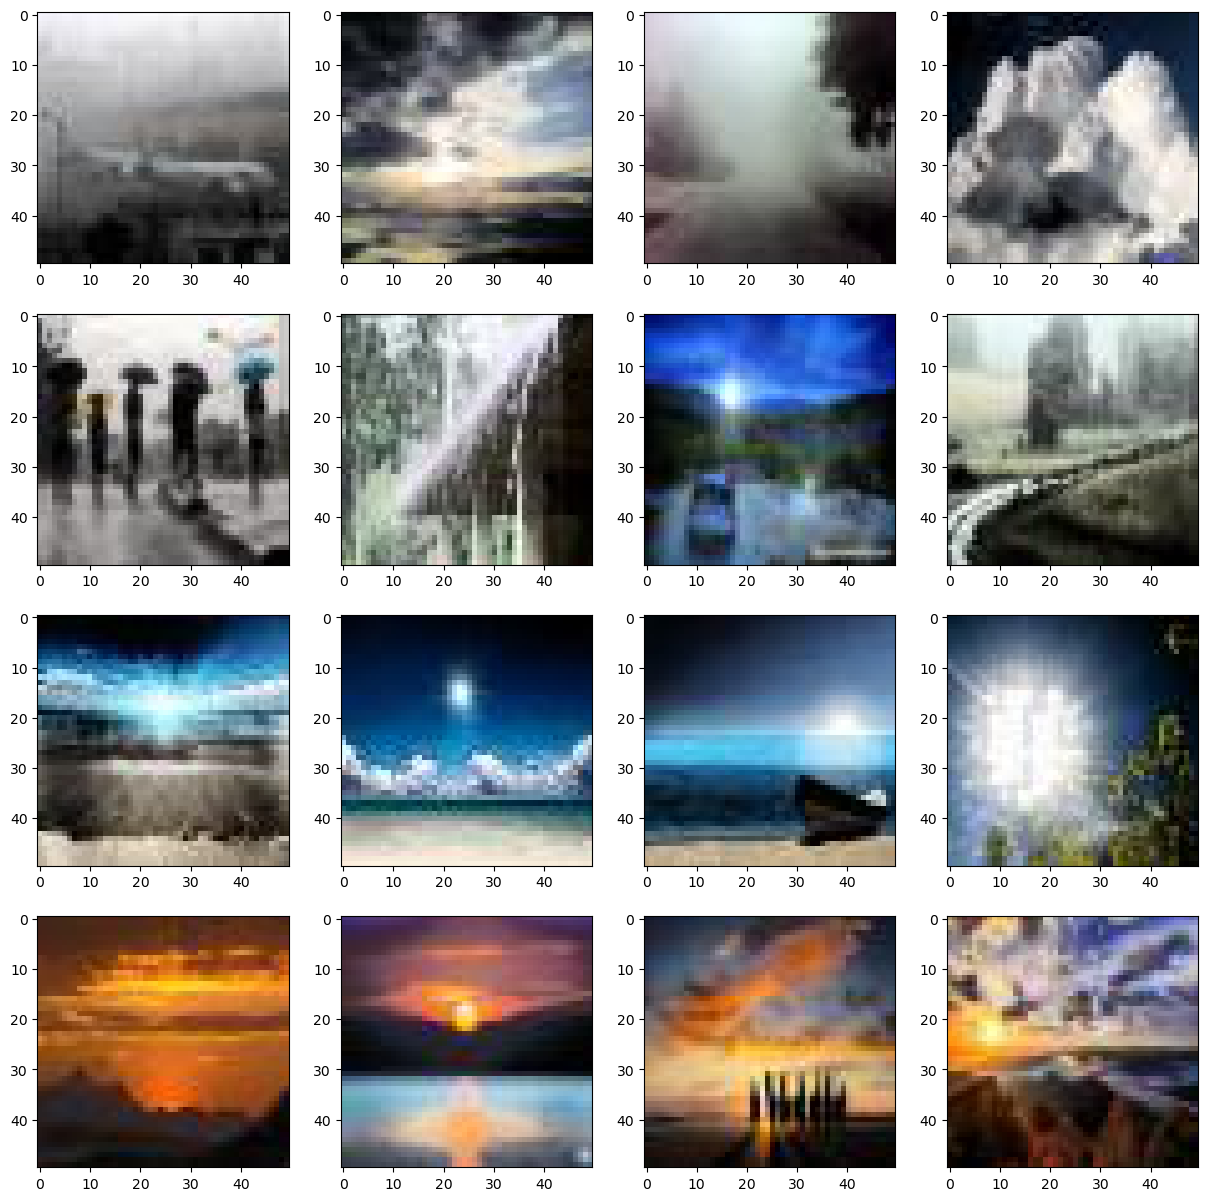

In [11]:
data_resized_eq = pd.read_csv("C:/Users/Lambert/Desktop/ML/weather_recognition/data_enhanced/data_R_50_EQ/data.csv",index_col=0)
show_ds(data_resized_eq)

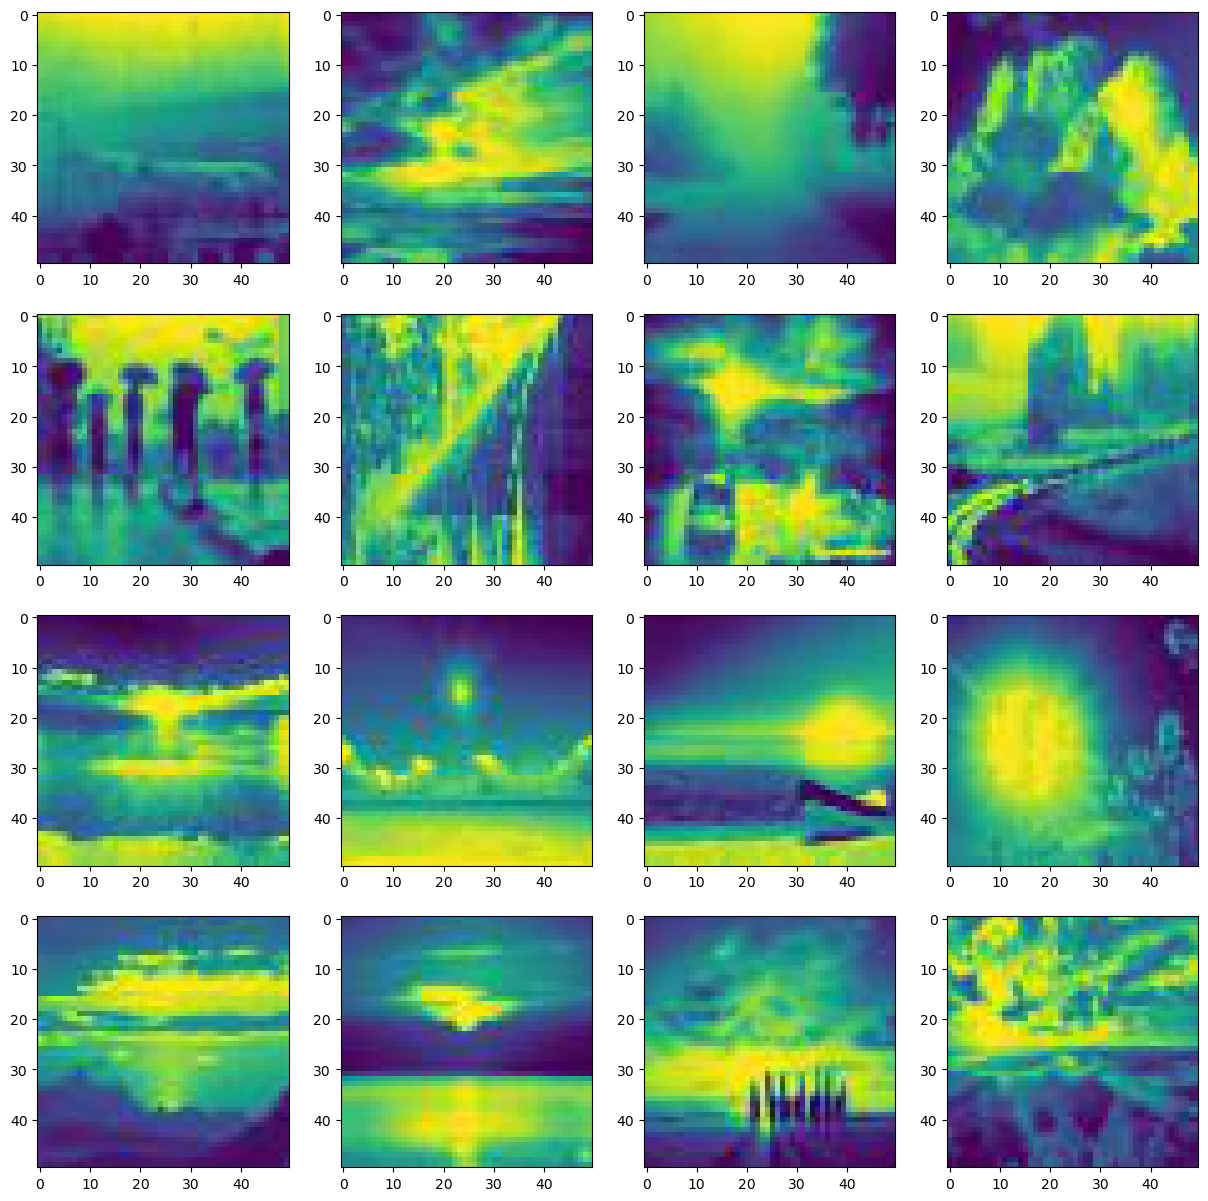

In [12]:
data_resized_eq_grey = pd.read_csv("C:/Users/Lambert/Desktop/ML/weather_recognition/data_enhanced/data_R_50_EQ_GR/data.csv",index_col=0)
show_ds(data_resized_eq_grey)

### Sub sampling the data

We have to split the data in a train set and a test set

In [59]:
def create_subset(data_set,size_train=0.8):
    x_test = pd.DataFrame(pd.DataFrame(columns = ["dir"]))
    x_train = pd.DataFrame(pd.DataFrame(columns = ["dir"]))
    y_test = pd.DataFrame(columns = ["Class","Class number","dir"])
    y_train = pd.DataFrame(columns = ["Class","Class number","dir"])
    for i in data_set["Class number"].unique():
        size = int(len(data_set.loc[data_df["Class number"]==i])*size_train)
        choice = np.random.choice(data_set.loc[data_df["Class number"]==i].index,size,replace=False)
        not_choice = np.setdiff1d(data_set.loc[data_df["Class number"]==i].index,choice)
        df_test = data_set.iloc[not_choice]
        df_train = data_set.iloc[choice]
        x_test = pd.concat((x_test,df_test),join="inner")
        y_test = pd.concat((y_test,df_test))
        x_train = pd.concat((x_train,df_train),join="inner")
        y_train = pd.concat((y_train,df_train))
    return x_test,y_test,x_train,y_train
x_test,y_test,x_train,y_train = create_subset(data_resized)

### Statistics

Open the training dataset

In [14]:
data_train = np.zeros((len(x_train.index),50,50,3))
associated_class = np.zeros((4,len(x_train.index)))
for k,i in tqdm(enumerate(x_train.index)):
    image = io.imread(x_train.loc[i]["dir"])
    data_train[k,:,:,:]=image
    associated_class[y_train.loc[i]["Class number"],k] = 1
    

899it [00:01, 666.94it/s]


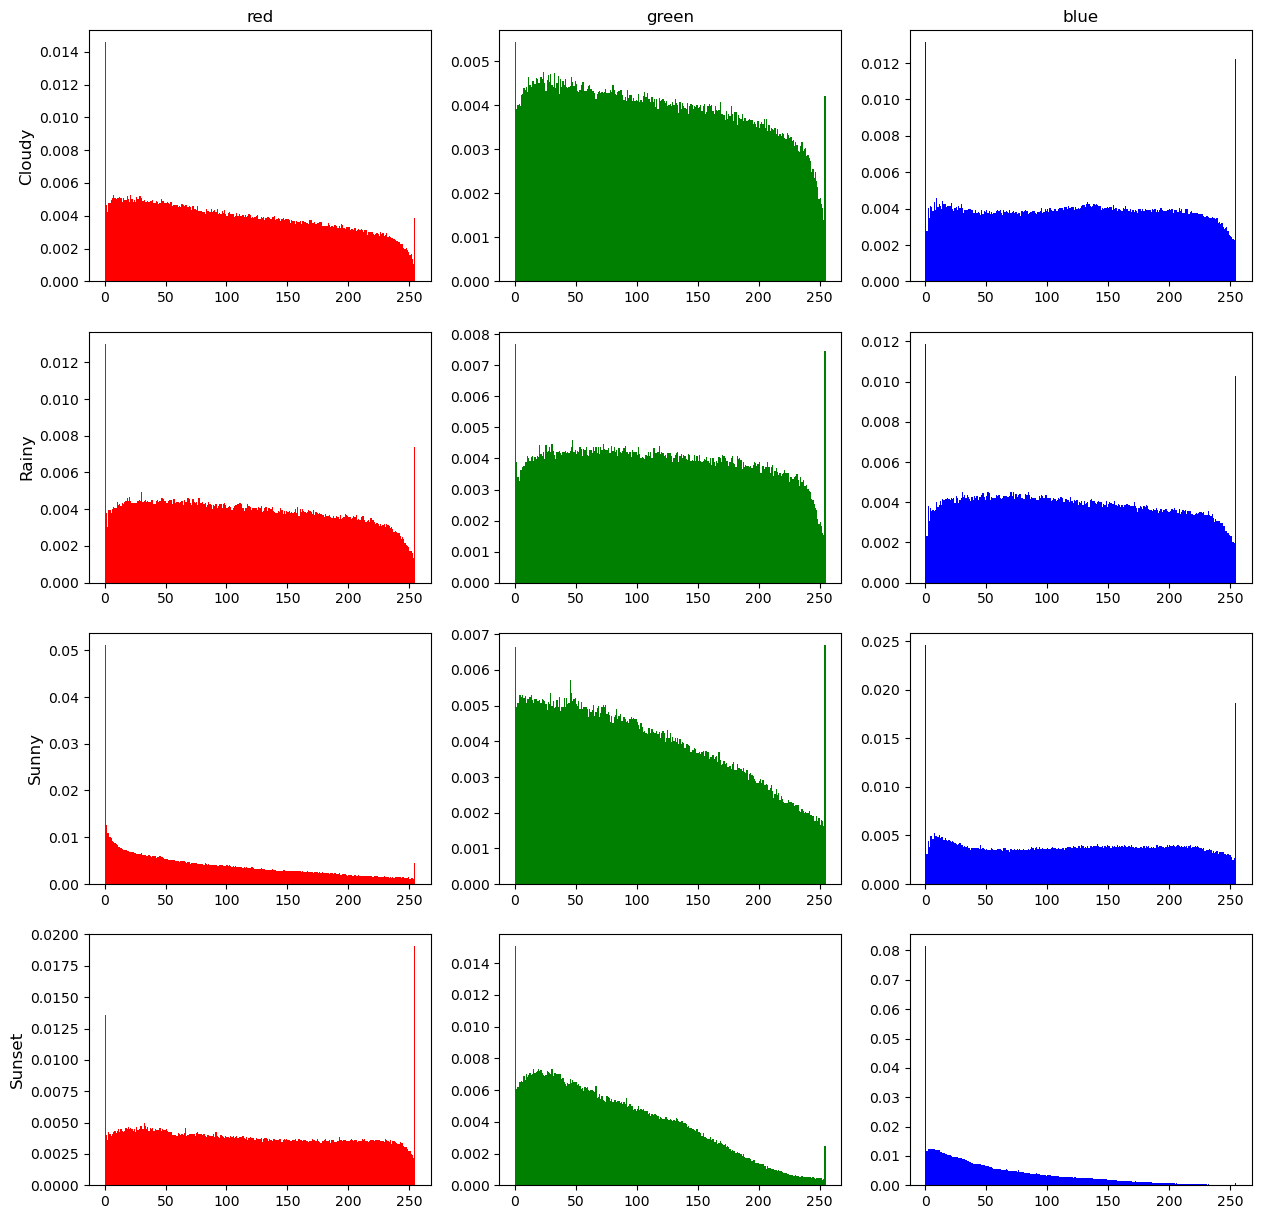

In [43]:
fig, axes  = plt.subplots(nrows = 4, ncols = 3,figsize = (15,15))
cols = ["red","green","blue"]
rows = ["Cloudy","Rainy","Sunny","Sunset"]
for ax,col in zip(axes[0],cols):
    ax.set_title(col)
for ax,row in zip(axes[:,0],rows):
    ax.set_ylabel(row,size = "large")
for i in y_test["Class number"].unique():
    plt.subplot(4,3,i*3+1)
    class_mask = (associated_class==i)
    red_pixels = data_train[class_mask,:,:,0]
    plt.hist(red_pixels.ravel(),bins=255,color="red",density = True)
    plt.subplot(4,3,i*3+2)
    green_pixels = data_train[class_mask,:,:,1]
    plt.hist(green_pixels.ravel(),bins=255,color="green",density = True)
    plt.subplot(4,3,i*3+3)
    blue_pixels = data_train[class_mask,:,:,2]
    plt.hist(blue_pixels.ravel(),bins=255,color="blue",density = True)
plt.show()

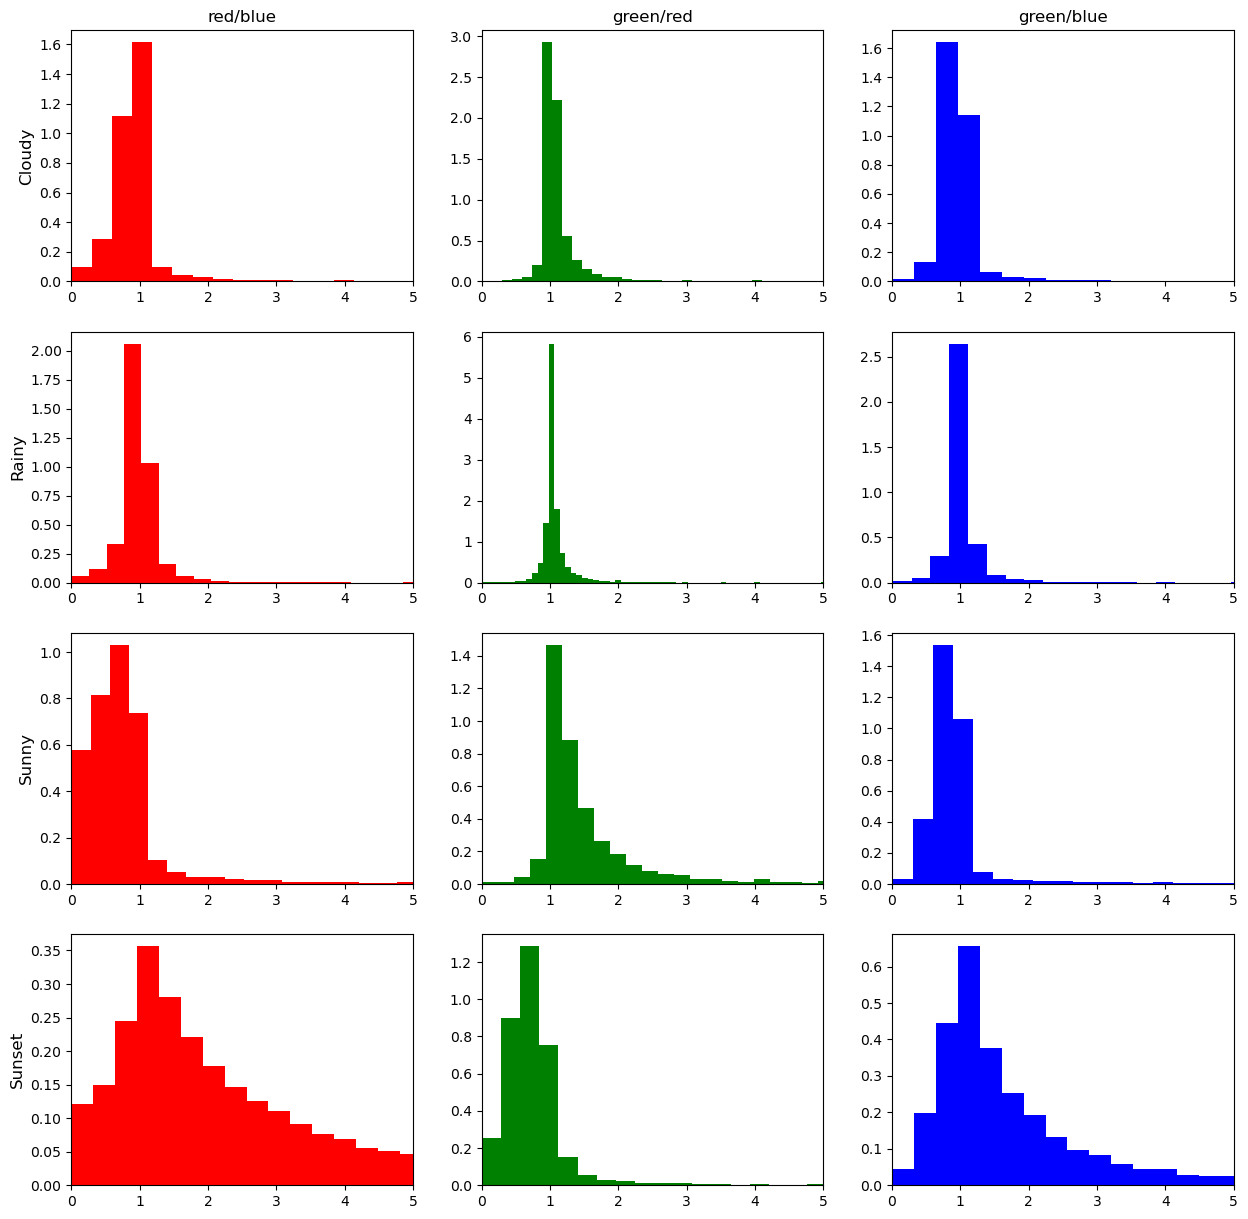

In [52]:
fig, axes  = plt.subplots(nrows = 4, ncols = 3,figsize = (15,15))
cols = ["red/blue","green/red","green/blue"]
rows = ["Cloudy","Rainy","Sunny","Sunset"]
for ax,col in zip(axes[0],cols):
    ax.set_title(col)
for ax,row in zip(axes[:,0],rows):
    ax.set_ylabel(row,size = "large")
for i in y_test["Class number"].unique():
    plt.subplot(4,3,i*3+1)
    class_mask = (associated_class==i)
    red_pixels = (data_train[class_mask,:,:,0]+1)/(data_train[class_mask,:,:,2]+1)
    plt.hist(red_pixels.ravel(),bins=800,color="red",density = True)
    plt.xlim(0,5)
    plt.subplot(4,3,i*3+2)
    green_pixels = (data_train[class_mask,:,:,1]+1)/(data_train[class_mask,:,:,0]+1)
    plt.hist(green_pixels.ravel(),bins=800,color="green",density = True)
    plt.xlim(0,5)
    plt.subplot(4,3,i*3+3)
    blue_pixels = (data_train[class_mask,:,:,1]+1)/(data_train[class_mask,:,:,2]+1)
    plt.hist(blue_pixels.ravel(),bins=800,color="blue",density = True)
    plt.xlim(0,5)
plt.show()

In [60]:
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(4, activation='softmax'))
    return model
n,lx,ly,lz = data_train.shape
model = get_model_v1(lx,ly,lz)

In [61]:
data_train = np.zeros((len(x_train.index),50,50,3))
result_train = np.zeros((len(x_train.index)))

data_val = np.zeros((len(x_test.index),50,50,3))
result_val = np.zeros((len(x_test.index)))

for k,i in tqdm(enumerate(x_train.index)):
    image = io.imread(x_train.loc[i]["dir"])
    data_train[k,:,:,:]=image.astype("float32")
    result_train[k] = y_train.loc[i]["Class number"]
for k,i in tqdm(enumerate(x_test.index)):
    image = io.imread(x_test.loc[i]["dir"])
    data_val[k,:,:,:]=image.astype("float32")
    result_val[k] = y_test.loc[i]["Class number"]    

899it [00:01, 589.09it/s]
226it [00:00, 447.13it/s]


In [62]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [63]:
history = model.fit(data_train, result_train, batch_size=50,
                                        
                                        epochs          = 20,
                                        verbose         = 1,
                                        validation_data = (data_val, result_val),
                                        callbacks       = [])
                    

Epoch 1/20
18/18 [==============================] - 18s 503ms/step - loss: 169.2825 - accuracy: 0.4071 - val_loss: 0.9141 - val_accuracy: 0.6504
Epoch 2/20
18/18 [==============================] - 6s 358ms/step - loss: 0.9990 - accuracy: 0.6685 - val_loss: 0.9530 - val_accuracy: 0.5664
Epoch 3/20
18/18 [==============================] - 6s 351ms/step - loss: 0.9055 - accuracy: 0.6885 - val_loss: 0.9857 - val_accuracy: 0.5442
Epoch 4/20
18/18 [==============================] - 6s 356ms/step - loss: 0.8005 - accuracy: 0.7097 - val_loss: 0.9251 - val_accuracy: 0.5885
Epoch 5/20
18/18 [==============================] - 7s 364ms/step - loss: 0.7607 - accuracy: 0.7230 - val_loss: 0.9195 - val_accuracy: 0.6195
Epoch 6/20
18/18 [==============================] - 7s 403ms/step - loss: 0.5757 - accuracy: 0.7909 - val_loss: 0.8931 - val_accuracy: 0.6062
Epoch 7/20
18/18 [==============================] - 7s 390ms/step - loss: 0.5348 - accuracy: 0.7831 - val_loss: 0.9033 - val_accuracy: 0.6150
Epo

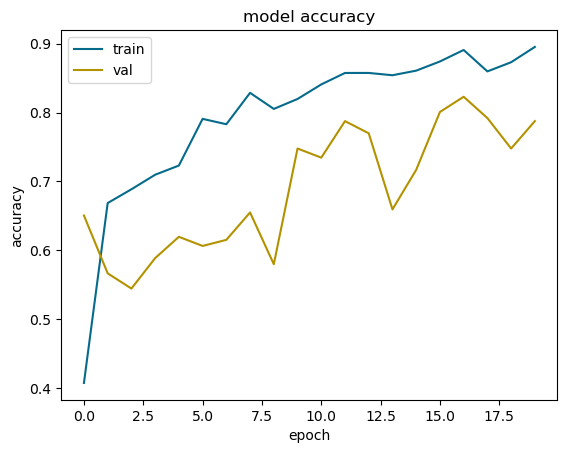

In [65]:
plt.plot(history.history['accuracy'], color='#066b8b')
plt.plot(history.history['val_accuracy'], color='#b39200')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

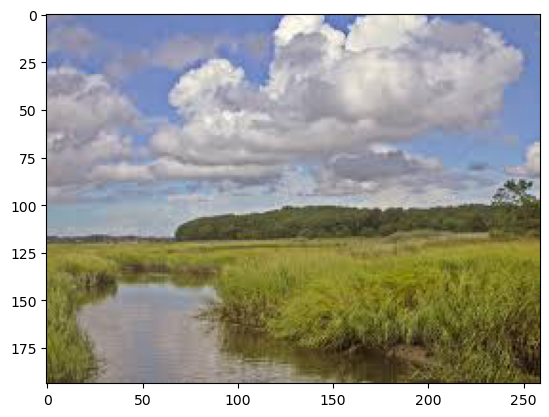

In [66]:
image = io.imread(data_df.loc[2,"dir"])
image_resized = resize(image, (50,50),anti_aliasing=True)

plt.imshow(image)

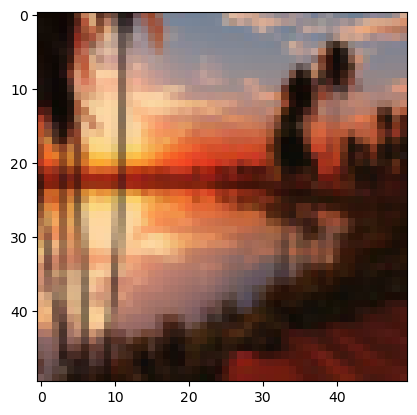

In [70]:
image = io.imread(data_df.loc[800,"dir"])
image = resize(image, (50,50),anti_aliasing=True)

plt.imshow(image)

In [71]:
model.predict(image[None,:,:,:],)

1/1 [==============================] - 0s 32ms/step


array([[0.2450955 , 0.6401215 , 0.06341362, 0.05136941]], dtype=float32)

In [25]:
class_good = [0,0,0,0]
class_err = [0,0,0,0]
pb = []
asspb = []
for i in (range(data_val.shape[0])):
    image = data_val[i,:,:,:]
    result = np.argmax(model.predict(image[None,:,:,:],))
    if result == result_val[i]:
        class_good[int(result_val[i])]+=1
    else : 
        class_err[int(result_val[i])]+=1
        pb.append(image)
        asspb.append(result)

1/1 [==============================] - 0s 35ms/step


In [26]:
class_good = np.array(class_good)
class_err = np.array(class_err)
class_good/(class_good+class_err)


array([0.88333333, 0.86046512, 0.62745098, 0.94444444])

In [181]:
class_good

array([42, 27, 30, 72])

In [182]:
class_err

array([18, 16, 21,  0])

0


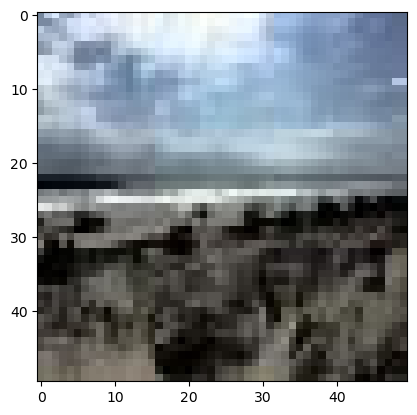

In [197]:
o = 54
plt.imshow(pb[o].astype('int32'))
print(asspb[o])

1